In [1]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Activation
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
wandb.init()
config = wandb.config

config.max_len = 32
config.buckets = 128

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

#labels=np.array(["chirping_birds", "crickets", "crow", 
#                 "frog", "insects"])
labels=np.array(["AAT", "AHV", "AMA", 
                 "ART", "ASI", "AVH",
                "AVT",
                "BRA", "BAM", "BBI", 
                 "BMA", "BIN",
                "GOC", "GRA", "GST", 
                 "GWG", "GWC",
                "OPI", "OQU", "OQY", "QOU"])

'''Saving vectors of label - 'AAT': 100%|█████████████████████████████████████████████████| 58/58 [00:01<00:00, 54.05it/s]
Saving vectors of label - 'AHV': 100%|█████████████████████████████████████████████████| 16/16 [00:00<00:00, 65.22it/s]
Saving vectors of label - 'AMA': 100%|█████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.26it/s]
Saving vectors of label - 'ART': 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.90it/s]
Saving vectors of label - 'ASI': 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.81it/s]
Saving vectors of label - 'AVH': 100%|█████████████████████████████████████████████████| 18/18 [00:00<00:00, 96.00it/s]
Saving vectors of label - 'AVT': 100%|███████████████████████████████████████████████| 222/222 [00:04<00:00, 50.72it/s]'''

Saving vectors of label - 'QOU': 100%|███████████████████████████████████████████████████| 6/6 [00:00<00:00, 52.77it/s]


"Saving vectors of label - 'AAT': 100%|█████████████████████████████████████████████████| 58/58 [00:01<00:00, 54.05it/s]\nSaving vectors of label - 'AHV': 100%|█████████████████████████████████████████████████| 16/16 [00:00<00:00, 65.22it/s]\nSaving vectors of label - 'AMA': 100%|█████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.26it/s]\nSaving vectors of label - 'ART': 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.90it/s]\nSaving vectors of label - 'ASI': 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.81it/s]\nSaving vectors of label - 'AVH': 100%|█████████████████████████████████████████████████| 18/18 [00:00<00:00, 96.00it/s]\nSaving vectors of label - 'AVT': 100%|███████████████████████████████████████████████| 222/222 [00:04<00:00, 50.72it/s]"

In [3]:
# Loading train/test set
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test()

In [4]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 50
config.batch_size = 100

# Number of classes
num_classes = 7
print(X_train.shape)
# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

(4104, 128, 32)


(4104, 128, 32, 1)


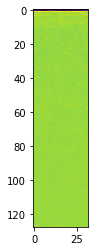

In [5]:
# Spectrogram visualized of 0th element
print(X_train.shape)
plt.imshow(X_train[200, :, :, 0])

In [6]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [7]:
# Building the model
model = Sequential()

input_shape= (config.buckets, config.max_len, channels)

model.add(Conv2D(21, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 1), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()
# Conv2D: 
#    Filters: 32
#    Kernel_size: (3,3) (height/width of the 2D convolution window)     
'''model.add(Conv2D(32, (3, 3),
    input_shape=(config.buckets, config.max_len, channels),
    activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))'''


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 6, 48)       

"model.add(Conv2D(32, (3, 3),\n    input_shape=(config.buckets, config.max_len, channels),\n    activation='relu'))\n\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(num_classes, activation='softmax'))"

In [8]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [9]:
wandb.init()
print(y_train_hot.shape)
print(labels.shape)
print(X_train.shape)
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

(4104, 21)
(21,)
(4104, 128, 32, 1)

Train on 4104 samples, validate on 2736 samples
Epoch 1/50
4104/4104 [==============================] - ETA: 2:21 - loss: 5.6301 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6175 - accuracy: 0.09 - ETA: 1:21 - loss: 4.3159 - accuracy: 0.12 - ETA: 1:08 - loss: 3.9500 - accuracy: 0.11 - ETA: 59s - loss: 3.6882 - accuracy: 0.1187 - ETA: 53s - loss: 3.4985 - accuracy: 0.135 - ETA: 50s - loss: 3.4140 - accuracy: 0.133 - ETA: 47s - loss: 3.3519 - accuracy: 0.132 - ETA: 44s - loss: 3.2648 - accuracy: 0.142 - ETA: 41s - loss: 3.1880 - accuracy: 0.153 - ETA: 39s - loss: 3.1581 - accuracy: 0.147 - ETA: 37s - loss: 3.1098 - accuracy: 0.151 - ETA: 36s - loss: 3.0808 - accuracy: 0.156 - ETA: 34s - loss: 3.0481 - accuracy: 0.160 - ETA: 33s - loss: 3.0068 - accuracy: 0.170 - ETA: 33s - loss: 2.9920 - accuracy: 0.181 - ETA: 33s - loss: 2.9549 - accuracy: 0.193 - ETA: 32s - loss: 2.9201 - accuracy: 0.199 - ETA: 31s - loss: 2.8850 - accuracy: 0.207 - ETA: 31s - loss: 2.848

4104/4104 [==============================] - ETA: 26s - loss: 1.6063 - accuracy: 0.656 - ETA: 23s - loss: 1.7114 - accuracy: 0.625 - ETA: 23s - loss: 1.5297 - accuracy: 0.645 - ETA: 23s - loss: 1.6111 - accuracy: 0.601 - ETA: 23s - loss: 1.7459 - accuracy: 0.568 - ETA: 23s - loss: 1.7824 - accuracy: 0.552 - ETA: 23s - loss: 1.7638 - accuracy: 0.540 - ETA: 24s - loss: 1.7730 - accuracy: 0.535 - ETA: 23s - loss: 1.7619 - accuracy: 0.527 - ETA: 24s - loss: 1.7603 - accuracy: 0.521 - ETA: 24s - loss: 1.7734 - accuracy: 0.519 - ETA: 24s - loss: 1.7478 - accuracy: 0.518 - ETA: 25s - loss: 1.7511 - accuracy: 0.516 - ETA: 25s - loss: 1.7570 - accuracy: 0.515 - ETA: 25s - loss: 1.7312 - accuracy: 0.525 - ETA: 26s - loss: 1.7235 - accuracy: 0.531 - ETA: 25s - loss: 1.7418 - accuracy: 0.523 - ETA: 25s - loss: 1.7274 - accuracy: 0.527 - ETA: 24s - loss: 1.7264 - accuracy: 0.524 - ETA: 24s - loss: 1.7304 - accuracy: 0.521 - ETA: 23s - loss: 1.7230 - accuracy: 0.517 - ETA: 23s - loss: 1.7200 - accur

4104/4104 [==============================] - ETA: 34s - loss: 1.3676 - accuracy: 0.531 - ETA: 39s - loss: 1.6690 - accuracy: 0.515 - ETA: 39s - loss: 1.7288 - accuracy: 0.489 - ETA: 37s - loss: 1.7366 - accuracy: 0.492 - ETA: 37s - loss: 1.6978 - accuracy: 0.500 - ETA: 40s - loss: 1.6828 - accuracy: 0.500 - ETA: 38s - loss: 1.7228 - accuracy: 0.495 - ETA: 36s - loss: 1.6861 - accuracy: 0.507 - ETA: 36s - loss: 1.6427 - accuracy: 0.527 - ETA: 35s - loss: 1.6126 - accuracy: 0.531 - ETA: 35s - loss: 1.6390 - accuracy: 0.528 - ETA: 36s - loss: 1.5965 - accuracy: 0.541 - ETA: 35s - loss: 1.5911 - accuracy: 0.533 - ETA: 33s - loss: 1.5622 - accuracy: 0.537 - ETA: 32s - loss: 1.6148 - accuracy: 0.537 - ETA: 31s - loss: 1.6053 - accuracy: 0.541 - ETA: 30s - loss: 1.6054 - accuracy: 0.542 - ETA: 29s - loss: 1.6222 - accuracy: 0.534 - ETA: 28s - loss: 1.6052 - accuracy: 0.546 - ETA: 27s - loss: 1.6108 - accuracy: 0.540 - ETA: 27s - loss: 1.5971 - accuracy: 0.544 - ETA: 27s - loss: 1.6017 - accur

4104/4104 [==============================] - ETA: 21s - loss: 1.5374 - accuracy: 0.531 - ETA: 23s - loss: 1.3423 - accuracy: 0.578 - ETA: 22s - loss: 1.3222 - accuracy: 0.541 - ETA: 22s - loss: 1.3148 - accuracy: 0.562 - ETA: 22s - loss: 1.3581 - accuracy: 0.568 - ETA: 22s - loss: 1.4092 - accuracy: 0.572 - ETA: 21s - loss: 1.4170 - accuracy: 0.571 - ETA: 21s - loss: 1.4230 - accuracy: 0.562 - ETA: 20s - loss: 1.4119 - accuracy: 0.572 - ETA: 20s - loss: 1.4348 - accuracy: 0.565 - ETA: 20s - loss: 1.4579 - accuracy: 0.562 - ETA: 20s - loss: 1.4866 - accuracy: 0.554 - ETA: 19s - loss: 1.4770 - accuracy: 0.555 - ETA: 19s - loss: 1.4793 - accuracy: 0.551 - ETA: 19s - loss: 1.4720 - accuracy: 0.547 - ETA: 19s - loss: 1.4663 - accuracy: 0.554 - ETA: 18s - loss: 1.4745 - accuracy: 0.558 - ETA: 18s - loss: 1.4849 - accuracy: 0.550 - ETA: 19s - loss: 1.4796 - accuracy: 0.554 - ETA: 20s - loss: 1.4862 - accuracy: 0.554 - ETA: 23s - loss: 1.4893 - accuracy: 0.556 - ETA: 22s - loss: 1.4789 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.9217 - accuracy: 0.718 - ETA: 19s - loss: 1.1596 - accuracy: 0.640 - ETA: 19s - loss: 1.1945 - accuracy: 0.645 - ETA: 19s - loss: 1.2027 - accuracy: 0.640 - ETA: 19s - loss: 1.2741 - accuracy: 0.612 - ETA: 18s - loss: 1.3137 - accuracy: 0.599 - ETA: 18s - loss: 1.2818 - accuracy: 0.607 - ETA: 18s - loss: 1.3308 - accuracy: 0.597 - ETA: 18s - loss: 1.3287 - accuracy: 0.597 - ETA: 18s - loss: 1.3300 - accuracy: 0.596 - ETA: 18s - loss: 1.3280 - accuracy: 0.593 - ETA: 18s - loss: 1.3352 - accuracy: 0.588 - ETA: 18s - loss: 1.3301 - accuracy: 0.591 - ETA: 18s - loss: 1.3397 - accuracy: 0.591 - ETA: 18s - loss: 1.3098 - accuracy: 0.602 - ETA: 18s - loss: 1.3012 - accuracy: 0.603 - ETA: 18s - loss: 1.2981 - accuracy: 0.608 - ETA: 18s - loss: 1.3036 - accuracy: 0.607 - ETA: 18s - loss: 1.3262 - accuracy: 0.597 - ETA: 18s - loss: 1.3068 - accuracy: 0.600 - ETA: 19s - loss: 1.2962 - accuracy: 0.601 - ETA: 19s - loss: 1.3070 - accur

4104/4104 [==============================] - ETA: 18s - loss: 1.4475 - accuracy: 0.468 - ETA: 18s - loss: 1.3341 - accuracy: 0.515 - ETA: 18s - loss: 1.1951 - accuracy: 0.593 - ETA: 18s - loss: 1.2122 - accuracy: 0.617 - ETA: 18s - loss: 1.2822 - accuracy: 0.600 - ETA: 18s - loss: 1.2545 - accuracy: 0.604 - ETA: 18s - loss: 1.2586 - accuracy: 0.611 - ETA: 18s - loss: 1.2434 - accuracy: 0.609 - ETA: 19s - loss: 1.2412 - accuracy: 0.604 - ETA: 18s - loss: 1.2262 - accuracy: 0.606 - ETA: 18s - loss: 1.2000 - accuracy: 0.616 - ETA: 18s - loss: 1.2079 - accuracy: 0.614 - ETA: 18s - loss: 1.1718 - accuracy: 0.620 - ETA: 18s - loss: 1.1688 - accuracy: 0.611 - ETA: 17s - loss: 1.1737 - accuracy: 0.618 - ETA: 17s - loss: 1.1736 - accuracy: 0.613 - ETA: 17s - loss: 1.1891 - accuracy: 0.604 - ETA: 17s - loss: 1.1943 - accuracy: 0.604 - ETA: 17s - loss: 1.1918 - accuracy: 0.602 - ETA: 17s - loss: 1.2107 - accuracy: 0.601 - ETA: 17s - loss: 1.2040 - accuracy: 0.607 - ETA: 17s - loss: 1.2017 - accur

4104/4104 [==============================] - ETA: 23s - loss: 1.1642 - accuracy: 0.625 - ETA: 24s - loss: 1.0737 - accuracy: 0.640 - ETA: 25s - loss: 1.2520 - accuracy: 0.635 - ETA: 24s - loss: 1.1648 - accuracy: 0.664 - ETA: 25s - loss: 1.1231 - accuracy: 0.675 - ETA: 25s - loss: 1.0572 - accuracy: 0.692 - ETA: 24s - loss: 1.0233 - accuracy: 0.705 - ETA: 24s - loss: 1.0117 - accuracy: 0.707 - ETA: 24s - loss: 1.0074 - accuracy: 0.701 - ETA: 25s - loss: 1.0376 - accuracy: 0.675 - ETA: 25s - loss: 1.0542 - accuracy: 0.667 - ETA: 24s - loss: 1.0579 - accuracy: 0.658 - ETA: 24s - loss: 1.0360 - accuracy: 0.668 - ETA: 24s - loss: 1.0375 - accuracy: 0.669 - ETA: 24s - loss: 1.0550 - accuracy: 0.668 - ETA: 23s - loss: 1.0592 - accuracy: 0.673 - ETA: 23s - loss: 1.0539 - accuracy: 0.669 - ETA: 23s - loss: 1.0552 - accuracy: 0.671 - ETA: 23s - loss: 1.0586 - accuracy: 0.667 - ETA: 23s - loss: 1.0594 - accuracy: 0.668 - ETA: 23s - loss: 1.0697 - accuracy: 0.665 - ETA: 22s - loss: 1.0583 - accur

4104/4104 [==============================] - ETA: 37s - loss: 1.3556 - accuracy: 0.625 - ETA: 30s - loss: 1.2191 - accuracy: 0.640 - ETA: 28s - loss: 1.1004 - accuracy: 0.666 - ETA: 26s - loss: 1.1603 - accuracy: 0.656 - ETA: 26s - loss: 1.1000 - accuracy: 0.650 - ETA: 25s - loss: 1.1196 - accuracy: 0.630 - ETA: 24s - loss: 1.1808 - accuracy: 0.620 - ETA: 24s - loss: 1.1655 - accuracy: 0.617 - ETA: 25s - loss: 1.2078 - accuracy: 0.593 - ETA: 25s - loss: 1.2124 - accuracy: 0.596 - ETA: 25s - loss: 1.1772 - accuracy: 0.613 - ETA: 25s - loss: 1.1850 - accuracy: 0.612 - ETA: 25s - loss: 1.1675 - accuracy: 0.622 - ETA: 25s - loss: 1.1468 - accuracy: 0.625 - ETA: 25s - loss: 1.1485 - accuracy: 0.622 - ETA: 25s - loss: 1.1392 - accuracy: 0.627 - ETA: 27s - loss: 1.1108 - accuracy: 0.637 - ETA: 26s - loss: 1.1017 - accuracy: 0.638 - ETA: 26s - loss: 1.1028 - accuracy: 0.641 - ETA: 25s - loss: 1.0862 - accuracy: 0.648 - ETA: 25s - loss: 1.0982 - accuracy: 0.642 - ETA: 25s - loss: 1.0898 - accur

4104/4104 [==============================] - ETA: 23s - loss: 0.9061 - accuracy: 0.593 - ETA: 24s - loss: 0.8969 - accuracy: 0.671 - ETA: 25s - loss: 0.8364 - accuracy: 0.687 - ETA: 24s - loss: 0.8722 - accuracy: 0.679 - ETA: 24s - loss: 0.8837 - accuracy: 0.693 - ETA: 26s - loss: 0.8940 - accuracy: 0.697 - ETA: 26s - loss: 0.9095 - accuracy: 0.683 - ETA: 27s - loss: 0.9414 - accuracy: 0.675 - ETA: 26s - loss: 0.9295 - accuracy: 0.677 - ETA: 27s - loss: 0.9195 - accuracy: 0.675 - ETA: 28s - loss: 0.9355 - accuracy: 0.673 - ETA: 28s - loss: 0.9214 - accuracy: 0.679 - ETA: 29s - loss: 0.9325 - accuracy: 0.670 - ETA: 30s - loss: 0.9397 - accuracy: 0.669 - ETA: 30s - loss: 0.9240 - accuracy: 0.675 - ETA: 29s - loss: 0.9335 - accuracy: 0.671 - ETA: 29s - loss: 0.9180 - accuracy: 0.672 - ETA: 29s - loss: 0.9181 - accuracy: 0.675 - ETA: 29s - loss: 0.9223 - accuracy: 0.674 - ETA: 30s - loss: 0.9082 - accuracy: 0.675 - ETA: 31s - loss: 0.9023 - accuracy: 0.680 - ETA: 31s - loss: 0.9177 - accur

4104/4104 [==============================] - ETA: 23s - loss: 0.8686 - accuracy: 0.656 - ETA: 25s - loss: 0.7282 - accuracy: 0.703 - ETA: 32s - loss: 0.6964 - accuracy: 0.739 - ETA: 30s - loss: 0.8010 - accuracy: 0.742 - ETA: 28s - loss: 0.8304 - accuracy: 0.731 - ETA: 27s - loss: 0.8584 - accuracy: 0.724 - ETA: 27s - loss: 0.8340 - accuracy: 0.727 - ETA: 26s - loss: 0.8316 - accuracy: 0.722 - ETA: 25s - loss: 0.8421 - accuracy: 0.718 - ETA: 27s - loss: 0.8017 - accuracy: 0.740 - ETA: 27s - loss: 0.8115 - accuracy: 0.733 - ETA: 27s - loss: 0.8257 - accuracy: 0.729 - ETA: 27s - loss: 0.8308 - accuracy: 0.735 - ETA: 27s - loss: 0.8089 - accuracy: 0.745 - ETA: 26s - loss: 0.7942 - accuracy: 0.743 - ETA: 27s - loss: 0.8063 - accuracy: 0.742 - ETA: 27s - loss: 0.7953 - accuracy: 0.746 - ETA: 27s - loss: 0.8034 - accuracy: 0.743 - ETA: 27s - loss: 0.8088 - accuracy: 0.743 - ETA: 27s - loss: 0.8281 - accuracy: 0.735 - ETA: 27s - loss: 0.8230 - accuracy: 0.736 - ETA: 27s - loss: 0.8089 - accur

4104/4104 [==============================] - ETA: 20s - loss: 0.7144 - accuracy: 0.843 - ETA: 21s - loss: 0.8492 - accuracy: 0.765 - ETA: 21s - loss: 0.8412 - accuracy: 0.750 - ETA: 20s - loss: 0.9798 - accuracy: 0.734 - ETA: 24s - loss: 1.0428 - accuracy: 0.712 - ETA: 24s - loss: 0.9405 - accuracy: 0.739 - ETA: 23s - loss: 0.9029 - accuracy: 0.750 - ETA: 22s - loss: 0.8596 - accuracy: 0.757 - ETA: 21s - loss: 0.8816 - accuracy: 0.746 - ETA: 21s - loss: 0.8856 - accuracy: 0.740 - ETA: 20s - loss: 0.9010 - accuracy: 0.741 - ETA: 20s - loss: 0.9048 - accuracy: 0.739 - ETA: 19s - loss: 0.8830 - accuracy: 0.745 - ETA: 19s - loss: 0.8699 - accuracy: 0.750 - ETA: 19s - loss: 0.8626 - accuracy: 0.747 - ETA: 19s - loss: 0.8512 - accuracy: 0.750 - ETA: 19s - loss: 0.8631 - accuracy: 0.740 - ETA: 18s - loss: 0.8600 - accuracy: 0.739 - ETA: 18s - loss: 0.8940 - accuracy: 0.736 - ETA: 18s - loss: 0.8994 - accuracy: 0.734 - ETA: 18s - loss: 0.8972 - accuracy: 0.730 - ETA: 17s - loss: 0.9008 - accur

4104/4104 [==============================] - ETA: 27s - loss: 0.7226 - accuracy: 0.781 - ETA: 28s - loss: 0.7940 - accuracy: 0.734 - ETA: 39s - loss: 0.7088 - accuracy: 0.739 - ETA: 36s - loss: 0.6469 - accuracy: 0.773 - ETA: 33s - loss: 0.7124 - accuracy: 0.756 - ETA: 32s - loss: 0.7137 - accuracy: 0.750 - ETA: 33s - loss: 0.7007 - accuracy: 0.750 - ETA: 33s - loss: 0.7179 - accuracy: 0.742 - ETA: 32s - loss: 0.7352 - accuracy: 0.725 - ETA: 32s - loss: 0.7570 - accuracy: 0.721 - ETA: 32s - loss: 0.7541 - accuracy: 0.727 - ETA: 31s - loss: 0.7418 - accuracy: 0.729 - ETA: 29s - loss: 0.7556 - accuracy: 0.723 - ETA: 29s - loss: 0.7499 - accuracy: 0.727 - ETA: 28s - loss: 0.7460 - accuracy: 0.729 - ETA: 28s - loss: 0.7790 - accuracy: 0.720 - ETA: 28s - loss: 0.7793 - accuracy: 0.722 - ETA: 28s - loss: 0.8106 - accuracy: 0.715 - ETA: 28s - loss: 0.8182 - accuracy: 0.710 - ETA: 27s - loss: 0.8111 - accuracy: 0.718 - ETA: 27s - loss: 0.8058 - accuracy: 0.723 - ETA: 26s - loss: 0.8128 - accur

4104/4104 [==============================] - ETA: 36s - loss: 0.9784 - accuracy: 0.718 - ETA: 32s - loss: 0.8517 - accuracy: 0.750 - ETA: 34s - loss: 0.7768 - accuracy: 0.770 - ETA: 32s - loss: 0.8001 - accuracy: 0.742 - ETA: 29s - loss: 0.7557 - accuracy: 0.750 - ETA: 28s - loss: 0.7179 - accuracy: 0.760 - ETA: 28s - loss: 0.7154 - accuracy: 0.754 - ETA: 28s - loss: 0.7493 - accuracy: 0.750 - ETA: 27s - loss: 0.7635 - accuracy: 0.746 - ETA: 27s - loss: 0.7680 - accuracy: 0.746 - ETA: 27s - loss: 0.7512 - accuracy: 0.750 - ETA: 27s - loss: 0.7338 - accuracy: 0.757 - ETA: 26s - loss: 0.7271 - accuracy: 0.762 - ETA: 26s - loss: 0.7227 - accuracy: 0.761 - ETA: 25s - loss: 0.7156 - accuracy: 0.764 - ETA: 25s - loss: 0.7239 - accuracy: 0.757 - ETA: 25s - loss: 0.7152 - accuracy: 0.761 - ETA: 25s - loss: 0.7473 - accuracy: 0.753 - ETA: 25s - loss: 0.7323 - accuracy: 0.759 - ETA: 25s - loss: 0.7236 - accuracy: 0.764 - ETA: 25s - loss: 0.7320 - accuracy: 0.761 - ETA: 24s - loss: 0.7267 - accur

4104/4104 [==============================] - ETA: 25s - loss: 0.4734 - accuracy: 0.875 - ETA: 23s - loss: 0.4766 - accuracy: 0.859 - ETA: 22s - loss: 0.5174 - accuracy: 0.843 - ETA: 25s - loss: 0.4978 - accuracy: 0.828 - ETA: 25s - loss: 0.5049 - accuracy: 0.831 - ETA: 26s - loss: 0.5604 - accuracy: 0.802 - ETA: 26s - loss: 0.5792 - accuracy: 0.803 - ETA: 26s - loss: 0.5678 - accuracy: 0.808 - ETA: 27s - loss: 0.6159 - accuracy: 0.784 - ETA: 26s - loss: 0.5984 - accuracy: 0.787 - ETA: 26s - loss: 0.6038 - accuracy: 0.789 - ETA: 25s - loss: 0.6113 - accuracy: 0.786 - ETA: 25s - loss: 0.6203 - accuracy: 0.781 - ETA: 25s - loss: 0.6132 - accuracy: 0.783 - ETA: 25s - loss: 0.6303 - accuracy: 0.779 - ETA: 25s - loss: 0.6285 - accuracy: 0.781 - ETA: 25s - loss: 0.6204 - accuracy: 0.784 - ETA: 25s - loss: 0.6491 - accuracy: 0.781 - ETA: 24s - loss: 0.6575 - accuracy: 0.774 - ETA: 24s - loss: 0.6574 - accuracy: 0.775 - ETA: 24s - loss: 0.6568 - accuracy: 0.773 - ETA: 24s - loss: 0.6468 - accur

4104/4104 [==============================] - ETA: 33s - loss: 0.6908 - accuracy: 0.750 - ETA: 32s - loss: 0.6068 - accuracy: 0.796 - ETA: 32s - loss: 0.5532 - accuracy: 0.812 - ETA: 34s - loss: 0.5899 - accuracy: 0.804 - ETA: 36s - loss: 0.5855 - accuracy: 0.806 - ETA: 37s - loss: 0.5703 - accuracy: 0.812 - ETA: 37s - loss: 0.5872 - accuracy: 0.808 - ETA: 35s - loss: 0.6397 - accuracy: 0.816 - ETA: 34s - loss: 0.6592 - accuracy: 0.812 - ETA: 33s - loss: 0.6455 - accuracy: 0.806 - ETA: 33s - loss: 0.6190 - accuracy: 0.812 - ETA: 33s - loss: 0.6258 - accuracy: 0.809 - ETA: 33s - loss: 0.6356 - accuracy: 0.802 - ETA: 33s - loss: 0.6281 - accuracy: 0.805 - ETA: 32s - loss: 0.6333 - accuracy: 0.806 - ETA: 31s - loss: 0.6444 - accuracy: 0.800 - ETA: 31s - loss: 0.6375 - accuracy: 0.803 - ETA: 30s - loss: 0.6350 - accuracy: 0.800 - ETA: 30s - loss: 0.6186 - accuracy: 0.807 - ETA: 30s - loss: 0.6212 - accuracy: 0.806 - ETA: 31s - loss: 0.6162 - accuracy: 0.808 - ETA: 30s - loss: 0.6215 - accur

4104/4104 [==============================] - ETA: 21s - loss: 0.3888 - accuracy: 0.937 - ETA: 20s - loss: 0.3840 - accuracy: 0.890 - ETA: 19s - loss: 0.4244 - accuracy: 0.843 - ETA: 19s - loss: 0.4982 - accuracy: 0.812 - ETA: 19s - loss: 0.4683 - accuracy: 0.818 - ETA: 19s - loss: 0.5047 - accuracy: 0.807 - ETA: 19s - loss: 0.5691 - accuracy: 0.785 - ETA: 18s - loss: 0.5547 - accuracy: 0.793 - ETA: 18s - loss: 0.5498 - accuracy: 0.795 - ETA: 18s - loss: 0.5780 - accuracy: 0.787 - ETA: 18s - loss: 0.5675 - accuracy: 0.789 - ETA: 18s - loss: 0.5649 - accuracy: 0.796 - ETA: 18s - loss: 0.5744 - accuracy: 0.793 - ETA: 17s - loss: 0.5711 - accuracy: 0.792 - ETA: 17s - loss: 0.5708 - accuracy: 0.793 - ETA: 17s - loss: 0.5629 - accuracy: 0.794 - ETA: 17s - loss: 0.5602 - accuracy: 0.792 - ETA: 17s - loss: 0.5883 - accuracy: 0.783 - ETA: 17s - loss: 0.5912 - accuracy: 0.784 - ETA: 17s - loss: 0.5933 - accuracy: 0.784 - ETA: 16s - loss: 0.6039 - accuracy: 0.779 - ETA: 17s - loss: 0.6092 - accur

4104/4104 [==============================] - ETA: 1:13 - loss: 0.4958 - accuracy: 0.90 - ETA: 1:47 - loss: 0.4339 - accuracy: 0.87 - ETA: 1:47 - loss: 0.4538 - accuracy: 0.86 - ETA: 1:49 - loss: 0.4353 - accuracy: 0.85 - ETA: 1:39 - loss: 0.4788 - accuracy: 0.83 - ETA: 1:42 - loss: 0.4826 - accuracy: 0.83 - ETA: 1:35 - loss: 0.5045 - accuracy: 0.83 - ETA: 1:29 - loss: 0.5523 - accuracy: 0.80 - ETA: 1:25 - loss: 0.5428 - accuracy: 0.81 - ETA: 1:20 - loss: 0.5761 - accuracy: 0.80 - ETA: 1:17 - loss: 0.5650 - accuracy: 0.81 - ETA: 1:13 - loss: 0.5565 - accuracy: 0.82 - ETA: 1:10 - loss: 0.5616 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5637 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5632 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5668 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5757 - accuracy: 0.81 - ETA: 58s - loss: 0.5780 - accuracy: 0.8073 - ETA: 56s - loss: 0.5803 - accuracy: 0.807 - ETA: 54s - loss: 0.5707 - accuracy: 0.812 - ETA: 53s - loss: 0.5785 - accuracy: 0.809 - ETA: 51s - loss: 0.5729 - accu

4104/4104 [==============================] - ETA: 20s - loss: 0.4662 - accuracy: 0.843 - ETA: 27s - loss: 0.5366 - accuracy: 0.765 - ETA: 28s - loss: 0.6011 - accuracy: 0.750 - ETA: 26s - loss: 0.6047 - accuracy: 0.765 - ETA: 25s - loss: 0.6122 - accuracy: 0.762 - ETA: 25s - loss: 0.6042 - accuracy: 0.770 - ETA: 24s - loss: 0.5902 - accuracy: 0.772 - ETA: 23s - loss: 0.5844 - accuracy: 0.773 - ETA: 22s - loss: 0.5634 - accuracy: 0.784 - ETA: 22s - loss: 0.5674 - accuracy: 0.787 - ETA: 21s - loss: 0.5674 - accuracy: 0.784 - ETA: 21s - loss: 0.5843 - accuracy: 0.786 - ETA: 20s - loss: 0.5826 - accuracy: 0.790 - ETA: 20s - loss: 0.5819 - accuracy: 0.785 - ETA: 19s - loss: 0.5808 - accuracy: 0.789 - ETA: 19s - loss: 0.5675 - accuracy: 0.796 - ETA: 19s - loss: 0.5645 - accuracy: 0.799 - ETA: 19s - loss: 0.5539 - accuracy: 0.803 - ETA: 19s - loss: 0.5476 - accuracy: 0.809 - ETA: 18s - loss: 0.5497 - accuracy: 0.804 - ETA: 18s - loss: 0.5606 - accuracy: 0.799 - ETA: 18s - loss: 0.5564 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.5386 - accuracy: 0.781 - ETA: 18s - loss: 0.5760 - accuracy: 0.765 - ETA: 19s - loss: 0.5735 - accuracy: 0.760 - ETA: 19s - loss: 0.5405 - accuracy: 0.789 - ETA: 19s - loss: 0.5779 - accuracy: 0.781 - ETA: 19s - loss: 0.5623 - accuracy: 0.786 - ETA: 19s - loss: 0.5597 - accuracy: 0.790 - ETA: 19s - loss: 0.5916 - accuracy: 0.800 - ETA: 19s - loss: 0.5535 - accuracy: 0.812 - ETA: 19s - loss: 0.5675 - accuracy: 0.800 - ETA: 20s - loss: 0.5353 - accuracy: 0.812 - ETA: 21s - loss: 0.5239 - accuracy: 0.817 - ETA: 21s - loss: 0.5682 - accuracy: 0.810 - ETA: 21s - loss: 0.5894 - accuracy: 0.801 - ETA: 21s - loss: 0.5921 - accuracy: 0.800 - ETA: 21s - loss: 0.5896 - accuracy: 0.800 - ETA: 21s - loss: 0.5998 - accuracy: 0.794 - ETA: 21s - loss: 0.6071 - accuracy: 0.793 - ETA: 20s - loss: 0.6030 - accuracy: 0.796 - ETA: 20s - loss: 0.6007 - accuracy: 0.798 - ETA: 20s - loss: 0.6021 - accuracy: 0.799 - ETA: 20s - loss: 0.5914 - accur

4104/4104 [==============================] - ETA: 25s - loss: 0.6851 - accuracy: 0.843 - ETA: 25s - loss: 0.6351 - accuracy: 0.812 - ETA: 23s - loss: 0.6208 - accuracy: 0.802 - ETA: 22s - loss: 0.5924 - accuracy: 0.812 - ETA: 22s - loss: 0.6138 - accuracy: 0.781 - ETA: 21s - loss: 0.6251 - accuracy: 0.765 - ETA: 21s - loss: 0.5962 - accuracy: 0.776 - ETA: 20s - loss: 0.6237 - accuracy: 0.781 - ETA: 20s - loss: 0.6354 - accuracy: 0.767 - ETA: 20s - loss: 0.6404 - accuracy: 0.768 - ETA: 20s - loss: 0.6526 - accuracy: 0.755 - ETA: 19s - loss: 0.6213 - accuracy: 0.770 - ETA: 19s - loss: 0.6332 - accuracy: 0.769 - ETA: 19s - loss: 0.6445 - accuracy: 0.770 - ETA: 19s - loss: 0.6450 - accuracy: 0.772 - ETA: 20s - loss: 0.6432 - accuracy: 0.773 - ETA: 19s - loss: 0.6311 - accuracy: 0.781 - ETA: 19s - loss: 0.6316 - accuracy: 0.784 - ETA: 19s - loss: 0.6188 - accuracy: 0.786 - ETA: 19s - loss: 0.6217 - accuracy: 0.781 - ETA: 18s - loss: 0.6227 - accuracy: 0.781 - ETA: 18s - loss: 0.6186 - accur

4104/4104 [==============================] - ETA: 39s - loss: 0.5631 - accuracy: 0.875 - ETA: 31s - loss: 0.4207 - accuracy: 0.906 - ETA: 27s - loss: 0.4635 - accuracy: 0.864 - ETA: 26s - loss: 0.4530 - accuracy: 0.859 - ETA: 25s - loss: 0.5210 - accuracy: 0.825 - ETA: 24s - loss: 0.5515 - accuracy: 0.807 - ETA: 23s - loss: 0.5267 - accuracy: 0.817 - ETA: 23s - loss: 0.5229 - accuracy: 0.816 - ETA: 22s - loss: 0.5154 - accuracy: 0.812 - ETA: 22s - loss: 0.5104 - accuracy: 0.812 - ETA: 21s - loss: 0.5089 - accuracy: 0.806 - ETA: 21s - loss: 0.5186 - accuracy: 0.804 - ETA: 21s - loss: 0.5222 - accuracy: 0.802 - ETA: 21s - loss: 0.5062 - accuracy: 0.808 - ETA: 21s - loss: 0.5076 - accuracy: 0.804 - ETA: 21s - loss: 0.5191 - accuracy: 0.804 - ETA: 20s - loss: 0.5169 - accuracy: 0.797 - ETA: 20s - loss: 0.5166 - accuracy: 0.800 - ETA: 20s - loss: 0.5179 - accuracy: 0.801 - ETA: 19s - loss: 0.4998 - accuracy: 0.809 - ETA: 19s - loss: 0.4973 - accuracy: 0.811 - ETA: 19s - loss: 0.4865 - accur

4104/4104 [==============================] - ETA: 26s - loss: 0.5872 - accuracy: 0.781 - ETA: 23s - loss: 0.5252 - accuracy: 0.781 - ETA: 21s - loss: 0.4762 - accuracy: 0.802 - ETA: 21s - loss: 0.4583 - accuracy: 0.820 - ETA: 21s - loss: 0.4509 - accuracy: 0.818 - ETA: 20s - loss: 0.4871 - accuracy: 0.807 - ETA: 20s - loss: 0.5389 - accuracy: 0.794 - ETA: 20s - loss: 0.5587 - accuracy: 0.785 - ETA: 20s - loss: 0.5385 - accuracy: 0.791 - ETA: 20s - loss: 0.5497 - accuracy: 0.793 - ETA: 20s - loss: 0.5506 - accuracy: 0.786 - ETA: 19s - loss: 0.5452 - accuracy: 0.791 - ETA: 19s - loss: 0.5318 - accuracy: 0.798 - ETA: 19s - loss: 0.5129 - accuracy: 0.808 - ETA: 19s - loss: 0.5097 - accuracy: 0.808 - ETA: 18s - loss: 0.5032 - accuracy: 0.808 - ETA: 18s - loss: 0.5077 - accuracy: 0.808 - ETA: 18s - loss: 0.5045 - accuracy: 0.807 - ETA: 18s - loss: 0.5031 - accuracy: 0.807 - ETA: 18s - loss: 0.4994 - accuracy: 0.809 - ETA: 18s - loss: 0.4985 - accuracy: 0.809 - ETA: 18s - loss: 0.5027 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.3979 - accuracy: 0.843 - ETA: 18s - loss: 0.4422 - accuracy: 0.796 - ETA: 18s - loss: 0.5062 - accuracy: 0.822 - ETA: 18s - loss: 0.5282 - accuracy: 0.828 - ETA: 18s - loss: 0.4927 - accuracy: 0.837 - ETA: 18s - loss: 0.4830 - accuracy: 0.833 - ETA: 18s - loss: 0.4904 - accuracy: 0.830 - ETA: 18s - loss: 0.5223 - accuracy: 0.820 - ETA: 18s - loss: 0.5289 - accuracy: 0.816 - ETA: 18s - loss: 0.5248 - accuracy: 0.815 - ETA: 18s - loss: 0.5214 - accuracy: 0.818 - ETA: 17s - loss: 0.5101 - accuracy: 0.815 - ETA: 17s - loss: 0.5087 - accuracy: 0.814 - ETA: 17s - loss: 0.4866 - accuracy: 0.819 - ETA: 17s - loss: 0.4868 - accuracy: 0.818 - ETA: 17s - loss: 0.4752 - accuracy: 0.822 - ETA: 17s - loss: 0.4678 - accuracy: 0.825 - ETA: 17s - loss: 0.4818 - accuracy: 0.819 - ETA: 16s - loss: 0.4816 - accuracy: 0.820 - ETA: 16s - loss: 0.4792 - accuracy: 0.823 - ETA: 16s - loss: 0.4700 - accuracy: 0.827 - ETA: 16s - loss: 0.4611 - accur

4104/4104 [==============================] - ETA: 19s - loss: 0.5016 - accuracy: 0.812 - ETA: 19s - loss: 0.4827 - accuracy: 0.843 - ETA: 20s - loss: 0.5174 - accuracy: 0.802 - ETA: 23s - loss: 0.4627 - accuracy: 0.828 - ETA: 23s - loss: 0.4813 - accuracy: 0.818 - ETA: 22s - loss: 0.4798 - accuracy: 0.812 - ETA: 21s - loss: 0.4728 - accuracy: 0.812 - ETA: 20s - loss: 0.4669 - accuracy: 0.824 - ETA: 20s - loss: 0.4719 - accuracy: 0.829 - ETA: 20s - loss: 0.4775 - accuracy: 0.821 - ETA: 19s - loss: 0.4781 - accuracy: 0.818 - ETA: 19s - loss: 0.4722 - accuracy: 0.820 - ETA: 18s - loss: 0.4702 - accuracy: 0.822 - ETA: 18s - loss: 0.4761 - accuracy: 0.817 - ETA: 19s - loss: 0.4569 - accuracy: 0.825 - ETA: 20s - loss: 0.4510 - accuracy: 0.832 - ETA: 20s - loss: 0.4514 - accuracy: 0.829 - ETA: 20s - loss: 0.4688 - accuracy: 0.819 - ETA: 19s - loss: 0.4549 - accuracy: 0.824 - ETA: 19s - loss: 0.4536 - accuracy: 0.826 - ETA: 19s - loss: 0.4430 - accuracy: 0.833 - ETA: 20s - loss: 0.4482 - accur

4104/4104 [==============================] - ETA: 27s - loss: 0.5834 - accuracy: 0.750 - ETA: 24s - loss: 0.4137 - accuracy: 0.843 - ETA: 26s - loss: 0.4027 - accuracy: 0.854 - ETA: 25s - loss: 0.4032 - accuracy: 0.851 - ETA: 26s - loss: 0.4119 - accuracy: 0.843 - ETA: 25s - loss: 0.4460 - accuracy: 0.828 - ETA: 25s - loss: 0.4335 - accuracy: 0.834 - ETA: 25s - loss: 0.4200 - accuracy: 0.839 - ETA: 25s - loss: 0.4319 - accuracy: 0.836 - ETA: 25s - loss: 0.4162 - accuracy: 0.843 - ETA: 25s - loss: 0.4402 - accuracy: 0.840 - ETA: 24s - loss: 0.4520 - accuracy: 0.830 - ETA: 24s - loss: 0.4445 - accuracy: 0.834 - ETA: 24s - loss: 0.4420 - accuracy: 0.834 - ETA: 23s - loss: 0.4339 - accuracy: 0.833 - ETA: 23s - loss: 0.4550 - accuracy: 0.828 - ETA: 23s - loss: 0.4480 - accuracy: 0.832 - ETA: 23s - loss: 0.4471 - accuracy: 0.831 - ETA: 23s - loss: 0.4556 - accuracy: 0.827 - ETA: 22s - loss: 0.4598 - accuracy: 0.826 - ETA: 22s - loss: 0.4588 - accuracy: 0.825 - ETA: 22s - loss: 0.4602 - accur

4104/4104 [==============================] - ETA: 25s - loss: 0.4653 - accuracy: 0.875 - ETA: 24s - loss: 0.4378 - accuracy: 0.875 - ETA: 23s - loss: 0.5219 - accuracy: 0.875 - ETA: 23s - loss: 0.5152 - accuracy: 0.859 - ETA: 22s - loss: 0.5395 - accuracy: 0.837 - ETA: 22s - loss: 0.4989 - accuracy: 0.843 - ETA: 22s - loss: 0.5077 - accuracy: 0.839 - ETA: 21s - loss: 0.4635 - accuracy: 0.855 - ETA: 21s - loss: 0.4649 - accuracy: 0.850 - ETA: 23s - loss: 0.4462 - accuracy: 0.856 - ETA: 23s - loss: 0.4185 - accuracy: 0.869 - ETA: 22s - loss: 0.4051 - accuracy: 0.869 - ETA: 22s - loss: 0.4036 - accuracy: 0.870 - ETA: 22s - loss: 0.4028 - accuracy: 0.866 - ETA: 21s - loss: 0.4016 - accuracy: 0.862 - ETA: 21s - loss: 0.4166 - accuracy: 0.859 - ETA: 21s - loss: 0.4146 - accuracy: 0.860 - ETA: 21s - loss: 0.4107 - accuracy: 0.857 - ETA: 21s - loss: 0.4024 - accuracy: 0.861 - ETA: 21s - loss: 0.4031 - accuracy: 0.864 - ETA: 21s - loss: 0.4142 - accuracy: 0.863 - ETA: 25s - loss: 0.4179 - accur

4104/4104 [==============================] - ETA: 24s - loss: 0.5981 - accuracy: 0.750 - ETA: 23s - loss: 0.4186 - accuracy: 0.828 - ETA: 23s - loss: 0.4627 - accuracy: 0.812 - ETA: 23s - loss: 0.4492 - accuracy: 0.820 - ETA: 22s - loss: 0.4419 - accuracy: 0.825 - ETA: 23s - loss: 0.5064 - accuracy: 0.807 - ETA: 24s - loss: 0.4813 - accuracy: 0.821 - ETA: 24s - loss: 0.4985 - accuracy: 0.820 - ETA: 23s - loss: 0.5199 - accuracy: 0.812 - ETA: 23s - loss: 0.4937 - accuracy: 0.821 - ETA: 24s - loss: 0.4755 - accuracy: 0.829 - ETA: 24s - loss: 0.4802 - accuracy: 0.825 - ETA: 23s - loss: 0.4863 - accuracy: 0.826 - ETA: 23s - loss: 0.4877 - accuracy: 0.825 - ETA: 22s - loss: 0.4850 - accuracy: 0.829 - ETA: 22s - loss: 0.4884 - accuracy: 0.830 - ETA: 22s - loss: 0.4839 - accuracy: 0.832 - ETA: 22s - loss: 0.4846 - accuracy: 0.829 - ETA: 22s - loss: 0.4837 - accuracy: 0.833 - ETA: 22s - loss: 0.4840 - accuracy: 0.829 - ETA: 21s - loss: 0.4701 - accuracy: 0.834 - ETA: 21s - loss: 0.4784 - accur

4104/4104 [==============================] - ETA: 50s - loss: 0.3331 - accuracy: 0.843 - ETA: 54s - loss: 0.3894 - accuracy: 0.843 - ETA: 50s - loss: 0.3655 - accuracy: 0.875 - ETA: 47s - loss: 0.3322 - accuracy: 0.890 - ETA: 46s - loss: 0.3261 - accuracy: 0.887 - ETA: 43s - loss: 0.3280 - accuracy: 0.885 - ETA: 42s - loss: 0.3185 - accuracy: 0.879 - ETA: 44s - loss: 0.2986 - accuracy: 0.886 - ETA: 43s - loss: 0.3153 - accuracy: 0.878 - ETA: 42s - loss: 0.3278 - accuracy: 0.875 - ETA: 40s - loss: 0.3155 - accuracy: 0.880 - ETA: 38s - loss: 0.3239 - accuracy: 0.877 - ETA: 37s - loss: 0.3279 - accuracy: 0.877 - ETA: 36s - loss: 0.3227 - accuracy: 0.877 - ETA: 35s - loss: 0.3229 - accuracy: 0.877 - ETA: 35s - loss: 0.3367 - accuracy: 0.871 - ETA: 35s - loss: 0.3354 - accuracy: 0.871 - ETA: 34s - loss: 0.3311 - accuracy: 0.871 - ETA: 33s - loss: 0.3292 - accuracy: 0.871 - ETA: 32s - loss: 0.3285 - accuracy: 0.871 - ETA: 31s - loss: 0.3374 - accuracy: 0.870 - ETA: 31s - loss: 0.3519 - accur

4104/4104 [==============================] - ETA: 17s - loss: 0.5402 - accuracy: 0.781 - ETA: 22s - loss: 0.4415 - accuracy: 0.843 - ETA: 23s - loss: 0.3999 - accuracy: 0.843 - ETA: 22s - loss: 0.4832 - accuracy: 0.820 - ETA: 22s - loss: 0.4442 - accuracy: 0.837 - ETA: 22s - loss: 0.4196 - accuracy: 0.838 - ETA: 22s - loss: 0.4653 - accuracy: 0.830 - ETA: 22s - loss: 0.4918 - accuracy: 0.812 - ETA: 21s - loss: 0.4735 - accuracy: 0.819 - ETA: 21s - loss: 0.4646 - accuracy: 0.825 - ETA: 20s - loss: 0.4446 - accuracy: 0.829 - ETA: 20s - loss: 0.4452 - accuracy: 0.828 - ETA: 20s - loss: 0.4374 - accuracy: 0.831 - ETA: 20s - loss: 0.4427 - accuracy: 0.832 - ETA: 19s - loss: 0.4348 - accuracy: 0.835 - ETA: 19s - loss: 0.4332 - accuracy: 0.835 - ETA: 19s - loss: 0.4275 - accuracy: 0.834 - ETA: 19s - loss: 0.4327 - accuracy: 0.835 - ETA: 19s - loss: 0.4204 - accuracy: 0.838 - ETA: 18s - loss: 0.4110 - accuracy: 0.842 - ETA: 18s - loss: 0.4109 - accuracy: 0.839 - ETA: 19s - loss: 0.4142 - accur

4104/4104 [==============================] - ETA: 52s - loss: 0.5372 - accuracy: 0.812 - ETA: 50s - loss: 0.3864 - accuracy: 0.875 - ETA: 42s - loss: 0.3895 - accuracy: 0.885 - ETA: 38s - loss: 0.4236 - accuracy: 0.890 - ETA: 39s - loss: 0.3933 - accuracy: 0.887 - ETA: 53s - loss: 0.4015 - accuracy: 0.880 - ETA: 51s - loss: 0.3904 - accuracy: 0.883 - ETA: 51s - loss: 0.4004 - accuracy: 0.878 - ETA: 50s - loss: 0.3875 - accuracy: 0.885 - ETA: 47s - loss: 0.4163 - accuracy: 0.878 - ETA: 45s - loss: 0.4321 - accuracy: 0.863 - ETA: 46s - loss: 0.4285 - accuracy: 0.862 - ETA: 45s - loss: 0.4261 - accuracy: 0.860 - ETA: 44s - loss: 0.4218 - accuracy: 0.861 - ETA: 44s - loss: 0.4193 - accuracy: 0.858 - ETA: 44s - loss: 0.4085 - accuracy: 0.859 - ETA: 44s - loss: 0.4004 - accuracy: 0.864 - ETA: 43s - loss: 0.4031 - accuracy: 0.861 - ETA: 42s - loss: 0.3934 - accuracy: 0.865 - ETA: 41s - loss: 0.3931 - accuracy: 0.862 - ETA: 40s - loss: 0.3959 - accuracy: 0.863 - ETA: 39s - loss: 0.3941 - accur

4104/4104 [==============================] - ETA: 19s - loss: 0.2717 - accuracy: 0.875 - ETA: 18s - loss: 0.2237 - accuracy: 0.890 - ETA: 19s - loss: 0.2674 - accuracy: 0.875 - ETA: 18s - loss: 0.3347 - accuracy: 0.859 - ETA: 18s - loss: 0.3669 - accuracy: 0.862 - ETA: 18s - loss: 0.4158 - accuracy: 0.838 - ETA: 18s - loss: 0.4152 - accuracy: 0.834 - ETA: 18s - loss: 0.4101 - accuracy: 0.839 - ETA: 18s - loss: 0.4091 - accuracy: 0.850 - ETA: 18s - loss: 0.3954 - accuracy: 0.856 - ETA: 19s - loss: 0.4008 - accuracy: 0.852 - ETA: 19s - loss: 0.3824 - accuracy: 0.859 - ETA: 19s - loss: 0.3839 - accuracy: 0.855 - ETA: 18s - loss: 0.3830 - accuracy: 0.854 - ETA: 18s - loss: 0.3958 - accuracy: 0.854 - ETA: 18s - loss: 0.3985 - accuracy: 0.857 - ETA: 18s - loss: 0.4093 - accuracy: 0.852 - ETA: 18s - loss: 0.4055 - accuracy: 0.857 - ETA: 18s - loss: 0.3976 - accuracy: 0.858 - ETA: 18s - loss: 0.3997 - accuracy: 0.857 - ETA: 18s - loss: 0.3921 - accuracy: 0.860 - ETA: 18s - loss: 0.3908 - accur

4104/4104 [==============================] - ETA: 23s - loss: 0.2732 - accuracy: 0.937 - ETA: 33s - loss: 0.3709 - accuracy: 0.875 - ETA: 32s - loss: 0.4162 - accuracy: 0.864 - ETA: 30s - loss: 0.4478 - accuracy: 0.843 - ETA: 31s - loss: 0.4075 - accuracy: 0.850 - ETA: 35s - loss: 0.3686 - accuracy: 0.869 - ETA: 33s - loss: 0.3636 - accuracy: 0.866 - ETA: 32s - loss: 0.3821 - accuracy: 0.863 - ETA: 30s - loss: 0.4046 - accuracy: 0.843 - ETA: 29s - loss: 0.4039 - accuracy: 0.843 - ETA: 28s - loss: 0.3994 - accuracy: 0.840 - ETA: 27s - loss: 0.4123 - accuracy: 0.841 - ETA: 27s - loss: 0.3943 - accuracy: 0.851 - ETA: 26s - loss: 0.4027 - accuracy: 0.850 - ETA: 25s - loss: 0.3872 - accuracy: 0.854 - ETA: 25s - loss: 0.3791 - accuracy: 0.857 - ETA: 25s - loss: 0.3916 - accuracy: 0.854 - ETA: 25s - loss: 0.3827 - accuracy: 0.861 - ETA: 24s - loss: 0.3868 - accuracy: 0.858 - ETA: 24s - loss: 0.3815 - accuracy: 0.862 - ETA: 23s - loss: 0.3904 - accuracy: 0.861 - ETA: 22s - loss: 0.3829 - accur

4104/4104 [==============================] - ETA: 26s - loss: 0.5294 - accuracy: 0.812 - ETA: 35s - loss: 0.3992 - accuracy: 0.875 - ETA: 30s - loss: 0.4087 - accuracy: 0.875 - ETA: 29s - loss: 0.3875 - accuracy: 0.882 - ETA: 30s - loss: 0.3735 - accuracy: 0.875 - ETA: 28s - loss: 0.3812 - accuracy: 0.875 - ETA: 28s - loss: 0.3674 - accuracy: 0.875 - ETA: 26s - loss: 0.3396 - accuracy: 0.886 - ETA: 26s - loss: 0.3627 - accuracy: 0.875 - ETA: 25s - loss: 0.3542 - accuracy: 0.875 - ETA: 24s - loss: 0.3552 - accuracy: 0.877 - ETA: 24s - loss: 0.3594 - accuracy: 0.877 - ETA: 24s - loss: 0.3451 - accuracy: 0.884 - ETA: 23s - loss: 0.3380 - accuracy: 0.886 - ETA: 23s - loss: 0.3220 - accuracy: 0.891 - ETA: 24s - loss: 0.3228 - accuracy: 0.892 - ETA: 24s - loss: 0.3215 - accuracy: 0.893 - ETA: 23s - loss: 0.3174 - accuracy: 0.894 - ETA: 23s - loss: 0.3147 - accuracy: 0.896 - ETA: 23s - loss: 0.3070 - accuracy: 0.900 - ETA: 22s - loss: 0.2997 - accuracy: 0.901 - ETA: 23s - loss: 0.3047 - accur

4104/4104 [==============================] - ETA: 19s - loss: 0.3075 - accuracy: 0.875 - ETA: 18s - loss: 0.2428 - accuracy: 0.921 - ETA: 19s - loss: 0.2079 - accuracy: 0.937 - ETA: 19s - loss: 0.2356 - accuracy: 0.929 - ETA: 18s - loss: 0.2687 - accuracy: 0.900 - ETA: 18s - loss: 0.2551 - accuracy: 0.911 - ETA: 19s - loss: 0.2747 - accuracy: 0.906 - ETA: 19s - loss: 0.2898 - accuracy: 0.906 - ETA: 19s - loss: 0.2984 - accuracy: 0.899 - ETA: 19s - loss: 0.3223 - accuracy: 0.893 - ETA: 19s - loss: 0.3404 - accuracy: 0.889 - ETA: 18s - loss: 0.3331 - accuracy: 0.893 - ETA: 18s - loss: 0.3332 - accuracy: 0.894 - ETA: 18s - loss: 0.3313 - accuracy: 0.895 - ETA: 18s - loss: 0.3303 - accuracy: 0.895 - ETA: 18s - loss: 0.3207 - accuracy: 0.900 - ETA: 17s - loss: 0.3211 - accuracy: 0.897 - ETA: 17s - loss: 0.3249 - accuracy: 0.895 - ETA: 17s - loss: 0.3220 - accuracy: 0.898 - ETA: 17s - loss: 0.3124 - accuracy: 0.901 - ETA: 17s - loss: 0.3073 - accuracy: 0.901 - ETA: 17s - loss: 0.3094 - accur

4104/4104 [==============================] - ETA: 21s - loss: 0.7628 - accuracy: 0.687 - ETA: 21s - loss: 0.4747 - accuracy: 0.781 - ETA: 21s - loss: 0.4450 - accuracy: 0.812 - ETA: 28s - loss: 0.4222 - accuracy: 0.820 - ETA: 32s - loss: 0.3821 - accuracy: 0.831 - ETA: 31s - loss: 0.3949 - accuracy: 0.833 - ETA: 31s - loss: 0.3628 - accuracy: 0.852 - ETA: 34s - loss: 0.3783 - accuracy: 0.847 - ETA: 34s - loss: 0.3646 - accuracy: 0.861 - ETA: 34s - loss: 0.3756 - accuracy: 0.856 - ETA: 32s - loss: 0.3969 - accuracy: 0.858 - ETA: 32s - loss: 0.3896 - accuracy: 0.862 - ETA: 31s - loss: 0.3759 - accuracy: 0.867 - ETA: 30s - loss: 0.3797 - accuracy: 0.866 - ETA: 30s - loss: 0.3697 - accuracy: 0.866 - ETA: 29s - loss: 0.3751 - accuracy: 0.861 - ETA: 29s - loss: 0.3711 - accuracy: 0.865 - ETA: 28s - loss: 0.3797 - accuracy: 0.861 - ETA: 27s - loss: 0.3699 - accuracy: 0.861 - ETA: 27s - loss: 0.3681 - accuracy: 0.865 - ETA: 27s - loss: 0.3777 - accuracy: 0.863 - ETA: 26s - loss: 0.3803 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.6828 - accuracy: 0.781 - ETA: 21s - loss: 0.4993 - accuracy: 0.828 - ETA: 23s - loss: 0.3954 - accuracy: 0.885 - ETA: 22s - loss: 0.3437 - accuracy: 0.890 - ETA: 23s - loss: 0.3651 - accuracy: 0.875 - ETA: 23s - loss: 0.3136 - accuracy: 0.895 - ETA: 23s - loss: 0.3016 - accuracy: 0.901 - ETA: 22s - loss: 0.2884 - accuracy: 0.902 - ETA: 21s - loss: 0.2756 - accuracy: 0.906 - ETA: 21s - loss: 0.2663 - accuracy: 0.909 - ETA: 21s - loss: 0.2576 - accuracy: 0.911 - ETA: 20s - loss: 0.2628 - accuracy: 0.906 - ETA: 20s - loss: 0.2507 - accuracy: 0.911 - ETA: 20s - loss: 0.2477 - accuracy: 0.910 - ETA: 19s - loss: 0.2450 - accuracy: 0.908 - ETA: 19s - loss: 0.2687 - accuracy: 0.900 - ETA: 19s - loss: 0.2634 - accuracy: 0.904 - ETA: 18s - loss: 0.2704 - accuracy: 0.902 - ETA: 18s - loss: 0.2621 - accuracy: 0.906 - ETA: 18s - loss: 0.2643 - accuracy: 0.904 - ETA: 18s - loss: 0.2650 - accuracy: 0.907 - ETA: 18s - loss: 0.2717 - accur

4104/4104 [==============================] - ETA: 23s - loss: 0.4626 - accuracy: 0.781 - ETA: 25s - loss: 0.4097 - accuracy: 0.812 - ETA: 26s - loss: 0.4580 - accuracy: 0.854 - ETA: 25s - loss: 0.4427 - accuracy: 0.867 - ETA: 24s - loss: 0.4178 - accuracy: 0.875 - ETA: 23s - loss: 0.4166 - accuracy: 0.875 - ETA: 22s - loss: 0.4374 - accuracy: 0.870 - ETA: 21s - loss: 0.5099 - accuracy: 0.859 - ETA: 21s - loss: 0.4683 - accuracy: 0.871 - ETA: 20s - loss: 0.4629 - accuracy: 0.868 - ETA: 20s - loss: 0.4790 - accuracy: 0.869 - ETA: 20s - loss: 0.4682 - accuracy: 0.869 - ETA: 19s - loss: 0.4531 - accuracy: 0.867 - ETA: 19s - loss: 0.4388 - accuracy: 0.872 - ETA: 19s - loss: 0.4278 - accuracy: 0.870 - ETA: 19s - loss: 0.4241 - accuracy: 0.869 - ETA: 19s - loss: 0.4168 - accuracy: 0.869 - ETA: 20s - loss: 0.4068 - accuracy: 0.873 - ETA: 20s - loss: 0.4150 - accuracy: 0.868 - ETA: 20s - loss: 0.4176 - accuracy: 0.867 - ETA: 20s - loss: 0.4185 - accuracy: 0.863 - ETA: 20s - loss: 0.4091 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.4240 - accuracy: 0.875 - ETA: 19s - loss: 0.3923 - accuracy: 0.875 - ETA: 19s - loss: 0.4373 - accuracy: 0.843 - ETA: 19s - loss: 0.4379 - accuracy: 0.859 - ETA: 18s - loss: 0.4204 - accuracy: 0.850 - ETA: 18s - loss: 0.4064 - accuracy: 0.859 - ETA: 18s - loss: 0.4104 - accuracy: 0.852 - ETA: 18s - loss: 0.3899 - accuracy: 0.859 - ETA: 18s - loss: 0.3935 - accuracy: 0.857 - ETA: 18s - loss: 0.3957 - accuracy: 0.859 - ETA: 18s - loss: 0.3707 - accuracy: 0.869 - ETA: 18s - loss: 0.3535 - accuracy: 0.875 - ETA: 17s - loss: 0.3516 - accuracy: 0.877 - ETA: 17s - loss: 0.3658 - accuracy: 0.875 - ETA: 17s - loss: 0.3564 - accuracy: 0.879 - ETA: 17s - loss: 0.3636 - accuracy: 0.877 - ETA: 17s - loss: 0.3632 - accuracy: 0.878 - ETA: 17s - loss: 0.3545 - accuracy: 0.880 - ETA: 16s - loss: 0.3527 - accuracy: 0.881 - ETA: 16s - loss: 0.3554 - accuracy: 0.879 - ETA: 17s - loss: 0.3545 - accuracy: 0.879 - ETA: 17s - loss: 0.3660 - accur

4104/4104 [==============================] - ETA: 29s - loss: 0.3505 - accuracy: 0.843 - ETA: 27s - loss: 0.3932 - accuracy: 0.843 - ETA: 31s - loss: 0.3341 - accuracy: 0.875 - ETA: 43s - loss: 0.3084 - accuracy: 0.875 - ETA: 44s - loss: 0.3116 - accuracy: 0.875 - ETA: 42s - loss: 0.3621 - accuracy: 0.869 - ETA: 40s - loss: 0.3489 - accuracy: 0.875 - ETA: 39s - loss: 0.3701 - accuracy: 0.863 - ETA: 39s - loss: 0.3552 - accuracy: 0.868 - ETA: 37s - loss: 0.3391 - accuracy: 0.871 - ETA: 36s - loss: 0.3230 - accuracy: 0.877 - ETA: 35s - loss: 0.3122 - accuracy: 0.880 - ETA: 34s - loss: 0.3038 - accuracy: 0.887 - ETA: 33s - loss: 0.2980 - accuracy: 0.886 - ETA: 37s - loss: 0.3056 - accuracy: 0.885 - ETA: 38s - loss: 0.3122 - accuracy: 0.884 - ETA: 38s - loss: 0.3255 - accuracy: 0.880 - ETA: 37s - loss: 0.3251 - accuracy: 0.878 - ETA: 36s - loss: 0.3164 - accuracy: 0.881 - ETA: 36s - loss: 0.3119 - accuracy: 0.884 - ETA: 36s - loss: 0.3036 - accuracy: 0.888 - ETA: 36s - loss: 0.2984 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.5574 - accuracy: 0.906 - ETA: 19s - loss: 0.3951 - accuracy: 0.906 - ETA: 36s - loss: 0.3487 - accuracy: 0.916 - ETA: 34s - loss: 0.3787 - accuracy: 0.890 - ETA: 33s - loss: 0.4147 - accuracy: 0.875 - ETA: 37s - loss: 0.3859 - accuracy: 0.885 - ETA: 34s - loss: 0.4216 - accuracy: 0.866 - ETA: 32s - loss: 0.4162 - accuracy: 0.859 - ETA: 30s - loss: 0.3932 - accuracy: 0.864 - ETA: 29s - loss: 0.3675 - accuracy: 0.871 - ETA: 28s - loss: 0.3601 - accuracy: 0.869 - ETA: 26s - loss: 0.3701 - accuracy: 0.862 - ETA: 25s - loss: 0.3660 - accuracy: 0.865 - ETA: 25s - loss: 0.3831 - accuracy: 0.866 - ETA: 24s - loss: 0.3990 - accuracy: 0.864 - ETA: 23s - loss: 0.4070 - accuracy: 0.857 - ETA: 23s - loss: 0.4040 - accuracy: 0.862 - ETA: 22s - loss: 0.3909 - accuracy: 0.866 - ETA: 22s - loss: 0.3976 - accuracy: 0.868 - ETA: 21s - loss: 0.3893 - accuracy: 0.873 - ETA: 21s - loss: 0.3874 - accuracy: 0.870 - ETA: 20s - loss: 0.3811 - accur

4104/4104 [==============================] - ETA: 59s - loss: 0.1980 - accuracy: 0.906 - ETA: 1:02 - loss: 0.2876 - accuracy: 0.85 - ETA: 56s - loss: 0.2640 - accuracy: 0.8854 - ETA: 48s - loss: 0.2897 - accuracy: 0.898 - ETA: 43s - loss: 0.2701 - accuracy: 0.906 - ETA: 39s - loss: 0.2906 - accuracy: 0.906 - ETA: 36s - loss: 0.2984 - accuracy: 0.892 - ETA: 35s - loss: 0.2835 - accuracy: 0.898 - ETA: 37s - loss: 0.3058 - accuracy: 0.888 - ETA: 37s - loss: 0.3142 - accuracy: 0.884 - ETA: 36s - loss: 0.3186 - accuracy: 0.883 - ETA: 34s - loss: 0.3400 - accuracy: 0.877 - ETA: 33s - loss: 0.3612 - accuracy: 0.872 - ETA: 32s - loss: 0.3769 - accuracy: 0.868 - ETA: 33s - loss: 0.3776 - accuracy: 0.870 - ETA: 33s - loss: 0.3731 - accuracy: 0.869 - ETA: 34s - loss: 0.3655 - accuracy: 0.873 - ETA: 33s - loss: 0.3604 - accuracy: 0.875 - ETA: 33s - loss: 0.3660 - accuracy: 0.871 - ETA: 32s - loss: 0.3771 - accuracy: 0.870 - ETA: 31s - loss: 0.3762 - accuracy: 0.872 - ETA: 31s - loss: 0.3727 - accu

4104/4104 [==============================] - ETA: 28s - loss: 0.3416 - accuracy: 0.843 - ETA: 29s - loss: 0.2957 - accuracy: 0.875 - ETA: 30s - loss: 0.2928 - accuracy: 0.864 - ETA: 30s - loss: 0.2687 - accuracy: 0.898 - ETA: 28s - loss: 0.2662 - accuracy: 0.900 - ETA: 27s - loss: 0.2966 - accuracy: 0.880 - ETA: 26s - loss: 0.3070 - accuracy: 0.883 - ETA: 26s - loss: 0.3195 - accuracy: 0.878 - ETA: 27s - loss: 0.3566 - accuracy: 0.868 - ETA: 27s - loss: 0.3424 - accuracy: 0.871 - ETA: 27s - loss: 0.3233 - accuracy: 0.880 - ETA: 27s - loss: 0.3225 - accuracy: 0.877 - ETA: 26s - loss: 0.3039 - accuracy: 0.884 - ETA: 26s - loss: 0.3117 - accuracy: 0.881 - ETA: 25s - loss: 0.2956 - accuracy: 0.889 - ETA: 25s - loss: 0.3035 - accuracy: 0.886 - ETA: 25s - loss: 0.3150 - accuracy: 0.884 - ETA: 25s - loss: 0.3122 - accuracy: 0.887 - ETA: 25s - loss: 0.3244 - accuracy: 0.886 - ETA: 25s - loss: 0.3179 - accuracy: 0.887 - ETA: 24s - loss: 0.3207 - accuracy: 0.885 - ETA: 24s - loss: 0.3328 - accur

4104/4104 [==============================] - ETA: 23s - loss: 0.4032 - accuracy: 0.875 - ETA: 24s - loss: 0.4161 - accuracy: 0.890 - ETA: 27s - loss: 0.3442 - accuracy: 0.895 - ETA: 29s - loss: 0.3108 - accuracy: 0.898 - ETA: 29s - loss: 0.2818 - accuracy: 0.906 - ETA: 28s - loss: 0.3052 - accuracy: 0.901 - ETA: 28s - loss: 0.3001 - accuracy: 0.910 - ETA: 31s - loss: 0.3009 - accuracy: 0.910 - ETA: 33s - loss: 0.3199 - accuracy: 0.909 - ETA: 33s - loss: 0.3035 - accuracy: 0.912 - ETA: 35s - loss: 0.2981 - accuracy: 0.906 - ETA: 36s - loss: 0.3279 - accuracy: 0.898 - ETA: 35s - loss: 0.3269 - accuracy: 0.894 - ETA: 34s - loss: 0.3234 - accuracy: 0.899 - ETA: 35s - loss: 0.3140 - accuracy: 0.902 - ETA: 34s - loss: 0.3044 - accuracy: 0.906 - ETA: 33s - loss: 0.3257 - accuracy: 0.897 - ETA: 32s - loss: 0.3267 - accuracy: 0.897 - ETA: 31s - loss: 0.3280 - accuracy: 0.896 - ETA: 31s - loss: 0.3200 - accuracy: 0.900 - ETA: 31s - loss: 0.3107 - accuracy: 0.901 - ETA: 31s - loss: 0.3129 - accur

4104/4104 [==============================] - ETA: 25s - loss: 0.1938 - accuracy: 0.906 - ETA: 24s - loss: 0.2013 - accuracy: 0.906 - ETA: 24s - loss: 0.3029 - accuracy: 0.864 - ETA: 22s - loss: 0.2677 - accuracy: 0.882 - ETA: 23s - loss: 0.2427 - accuracy: 0.893 - ETA: 23s - loss: 0.2769 - accuracy: 0.880 - ETA: 22s - loss: 0.2868 - accuracy: 0.875 - ETA: 22s - loss: 0.2720 - accuracy: 0.886 - ETA: 21s - loss: 0.2619 - accuracy: 0.895 - ETA: 21s - loss: 0.3001 - accuracy: 0.881 - ETA: 21s - loss: 0.3149 - accuracy: 0.875 - ETA: 21s - loss: 0.3047 - accuracy: 0.877 - ETA: 20s - loss: 0.3011 - accuracy: 0.877 - ETA: 21s - loss: 0.2958 - accuracy: 0.883 - ETA: 21s - loss: 0.2891 - accuracy: 0.887 - ETA: 20s - loss: 0.2950 - accuracy: 0.886 - ETA: 21s - loss: 0.2970 - accuracy: 0.886 - ETA: 20s - loss: 0.2985 - accuracy: 0.883 - ETA: 20s - loss: 0.3036 - accuracy: 0.883 - ETA: 20s - loss: 0.3066 - accuracy: 0.881 - ETA: 19s - loss: 0.2978 - accuracy: 0.885 - ETA: 19s - loss: 0.2991 - accur

4104/4104 [==============================] - ETA: 17s - loss: 0.1410 - accuracy: 0.968 - ETA: 20s - loss: 0.4174 - accuracy: 0.921 - ETA: 22s - loss: 0.3654 - accuracy: 0.916 - ETA: 22s - loss: 0.3319 - accuracy: 0.921 - ETA: 21s - loss: 0.3331 - accuracy: 0.912 - ETA: 21s - loss: 0.3517 - accuracy: 0.901 - ETA: 20s - loss: 0.3295 - accuracy: 0.901 - ETA: 20s - loss: 0.3281 - accuracy: 0.894 - ETA: 20s - loss: 0.3241 - accuracy: 0.892 - ETA: 19s - loss: 0.3205 - accuracy: 0.893 - ETA: 19s - loss: 0.3190 - accuracy: 0.892 - ETA: 20s - loss: 0.3050 - accuracy: 0.898 - ETA: 21s - loss: 0.3007 - accuracy: 0.899 - ETA: 22s - loss: 0.2832 - accuracy: 0.906 - ETA: 23s - loss: 0.2773 - accuracy: 0.910 - ETA: 24s - loss: 0.2900 - accuracy: 0.904 - ETA: 23s - loss: 0.2995 - accuracy: 0.904 - ETA: 23s - loss: 0.3072 - accuracy: 0.901 - ETA: 22s - loss: 0.3110 - accuracy: 0.896 - ETA: 22s - loss: 0.3426 - accuracy: 0.890 - ETA: 22s - loss: 0.3425 - accuracy: 0.891 - ETA: 21s - loss: 0.3336 - accur

4104/4104 [==============================] - ETA: 21s - loss: 0.2662 - accuracy: 0.906 - ETA: 24s - loss: 0.5049 - accuracy: 0.843 - ETA: 23s - loss: 0.4044 - accuracy: 0.875 - ETA: 24s - loss: 0.3537 - accuracy: 0.882 - ETA: 24s - loss: 0.3520 - accuracy: 0.881 - ETA: 23s - loss: 0.3162 - accuracy: 0.890 - ETA: 23s - loss: 0.3072 - accuracy: 0.892 - ETA: 22s - loss: 0.2976 - accuracy: 0.898 - ETA: 22s - loss: 0.3085 - accuracy: 0.892 - ETA: 21s - loss: 0.3034 - accuracy: 0.893 - ETA: 21s - loss: 0.3104 - accuracy: 0.886 - ETA: 21s - loss: 0.3117 - accuracy: 0.888 - ETA: 20s - loss: 0.3063 - accuracy: 0.889 - ETA: 20s - loss: 0.3187 - accuracy: 0.890 - ETA: 20s - loss: 0.3124 - accuracy: 0.893 - ETA: 19s - loss: 0.3116 - accuracy: 0.892 - ETA: 19s - loss: 0.3016 - accuracy: 0.895 - ETA: 19s - loss: 0.3077 - accuracy: 0.895 - ETA: 19s - loss: 0.3016 - accuracy: 0.896 - ETA: 18s - loss: 0.2999 - accuracy: 0.895 - ETA: 18s - loss: 0.3097 - accuracy: 0.891 - ETA: 18s - loss: 0.3108 - accur

4104/4104 [==============================] - ETA: 22s - loss: 0.5426 - accuracy: 0.843 - ETA: 22s - loss: 0.4045 - accuracy: 0.890 - ETA: 23s - loss: 0.3442 - accuracy: 0.916 - ETA: 23s - loss: 0.2938 - accuracy: 0.921 - ETA: 22s - loss: 0.3451 - accuracy: 0.906 - ETA: 22s - loss: 0.3206 - accuracy: 0.916 - ETA: 21s - loss: 0.3527 - accuracy: 0.901 - ETA: 21s - loss: 0.3298 - accuracy: 0.906 - ETA: 20s - loss: 0.3307 - accuracy: 0.902 - ETA: 20s - loss: 0.3086 - accuracy: 0.912 - ETA: 20s - loss: 0.3039 - accuracy: 0.909 - ETA: 20s - loss: 0.3023 - accuracy: 0.908 - ETA: 19s - loss: 0.3130 - accuracy: 0.906 - ETA: 19s - loss: 0.3058 - accuracy: 0.904 - ETA: 19s - loss: 0.3010 - accuracy: 0.902 - ETA: 19s - loss: 0.2970 - accuracy: 0.902 - ETA: 19s - loss: 0.2948 - accuracy: 0.900 - ETA: 20s - loss: 0.2937 - accuracy: 0.899 - ETA: 19s - loss: 0.2894 - accuracy: 0.898 - ETA: 19s - loss: 0.2887 - accuracy: 0.896 - ETA: 19s - loss: 0.2903 - accuracy: 0.898 - ETA: 19s - loss: 0.2798 - accur

4104/4104 [==============================] - ETA: 28s - loss: 0.2952 - accuracy: 0.906 - ETA: 26s - loss: 0.2550 - accuracy: 0.890 - ETA: 25s - loss: 0.2609 - accuracy: 0.885 - ETA: 24s - loss: 0.3023 - accuracy: 0.867 - ETA: 26s - loss: 0.3506 - accuracy: 0.850 - ETA: 25s - loss: 0.3638 - accuracy: 0.849 - ETA: 25s - loss: 0.3370 - accuracy: 0.861 - ETA: 25s - loss: 0.3199 - accuracy: 0.871 - ETA: 24s - loss: 0.3254 - accuracy: 0.864 - ETA: 23s - loss: 0.3082 - accuracy: 0.875 - ETA: 23s - loss: 0.2929 - accuracy: 0.883 - ETA: 23s - loss: 0.2927 - accuracy: 0.880 - ETA: 22s - loss: 0.2780 - accuracy: 0.884 - ETA: 22s - loss: 0.2694 - accuracy: 0.890 - ETA: 22s - loss: 0.2562 - accuracy: 0.895 - ETA: 22s - loss: 0.2677 - accuracy: 0.894 - ETA: 21s - loss: 0.2737 - accuracy: 0.891 - ETA: 21s - loss: 0.2770 - accuracy: 0.892 - ETA: 21s - loss: 0.2789 - accuracy: 0.896 - ETA: 21s - loss: 0.2690 - accuracy: 0.898 - ETA: 21s - loss: 0.2652 - accuracy: 0.900 - ETA: 20s - loss: 0.2615 - accur

4104/4104 [==============================] - ETA: 39s - loss: 0.6462 - accuracy: 0.843 - ETA: 36s - loss: 0.5665 - accuracy: 0.843 - ETA: 33s - loss: 0.4805 - accuracy: 0.875 - ETA: 30s - loss: 0.4036 - accuracy: 0.890 - ETA: 29s - loss: 0.3711 - accuracy: 0.893 - ETA: 28s - loss: 0.3533 - accuracy: 0.885 - ETA: 27s - loss: 0.3473 - accuracy: 0.883 - ETA: 26s - loss: 0.3142 - accuracy: 0.898 - ETA: 25s - loss: 0.3083 - accuracy: 0.892 - ETA: 25s - loss: 0.2938 - accuracy: 0.893 - ETA: 24s - loss: 0.2977 - accuracy: 0.894 - ETA: 25s - loss: 0.2896 - accuracy: 0.898 - ETA: 25s - loss: 0.2936 - accuracy: 0.894 - ETA: 24s - loss: 0.2831 - accuracy: 0.897 - ETA: 24s - loss: 0.2750 - accuracy: 0.902 - ETA: 24s - loss: 0.2861 - accuracy: 0.894 - ETA: 23s - loss: 0.2923 - accuracy: 0.891 - ETA: 23s - loss: 0.2979 - accuracy: 0.890 - ETA: 23s - loss: 0.2940 - accuracy: 0.891 - ETA: 23s - loss: 0.2927 - accuracy: 0.893 - ETA: 23s - loss: 0.3149 - accuracy: 0.888 - ETA: 23s - loss: 0.3065 - accur

4104/4104 [==============================] - ETA: 18s - loss: 0.2061 - accuracy: 0.906 - ETA: 18s - loss: 0.3419 - accuracy: 0.875 - ETA: 19s - loss: 0.2946 - accuracy: 0.895 - ETA: 18s - loss: 0.2614 - accuracy: 0.906 - ETA: 18s - loss: 0.2301 - accuracy: 0.925 - ETA: 18s - loss: 0.2257 - accuracy: 0.921 - ETA: 18s - loss: 0.2145 - accuracy: 0.924 - ETA: 18s - loss: 0.2207 - accuracy: 0.921 - ETA: 18s - loss: 0.2276 - accuracy: 0.927 - ETA: 18s - loss: 0.2194 - accuracy: 0.928 - ETA: 18s - loss: 0.2194 - accuracy: 0.926 - ETA: 18s - loss: 0.2439 - accuracy: 0.916 - ETA: 18s - loss: 0.2313 - accuracy: 0.920 - ETA: 17s - loss: 0.2258 - accuracy: 0.921 - ETA: 17s - loss: 0.2170 - accuracy: 0.925 - ETA: 17s - loss: 0.2114 - accuracy: 0.923 - ETA: 17s - loss: 0.2230 - accuracy: 0.921 - ETA: 17s - loss: 0.2187 - accuracy: 0.921 - ETA: 17s - loss: 0.2271 - accuracy: 0.919 - ETA: 16s - loss: 0.2257 - accuracy: 0.918 - ETA: 16s - loss: 0.2259 - accuracy: 0.918 - ETA: 16s - loss: 0.2265 - accur

In [10]:
# Save the keras model
model.save("ant_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [11]:
from keras.models import load_model

# Load the model
loaded_model = load_model('ant_cnn_model.h5')

In [12]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 6, 48)        

In [13]:
y_pred_ohe = loaded_model.predict(X_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape
print(confusion_matrix)

for class_i in range(len(labels)) :
    indices = np.argwhere(y_test == class_i)
    sum = 0
    for index in indices:
        sum += (y_test[index] == y_pred_labels[index])
    if(len(indices) > 0) : mean = sum/len(indices)
    else : mean = "N/A"
    print("Accuracy for class", labels[class_i], ":", mean)

print("Overall Accuracy :", np.mean(y_test == y_pred_labels))

'''Accuracy for class AAT : [0.46666667]
Accuracy for class AHV : [0.33333333]
Accuracy for class AMA : [0.125]
Accuracy for class ART : 0
Accuracy for class ASI : [0.]
Accuracy for class AVH : [0.6]
Accuracy for class AVT : [0.92307692]
Overall Accuracy : 0.676056338028169'''

[[ 36   0   0   0   0   0   5   0   7   0   0   0   0   0   0   1   0   1
    0   0   0]
 [  0   3   0   0   0   0   1   0   4   0   0   0   0   0   0   0   0   0
    1   0   0]
 [  0   0   7   0   0   0   3   0   6   1   0   0   0   0   0   0   0   0
    2   0   0]
 [  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  1   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   1
    0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0]
 [  6   0   4   0   0   0 106   8  64   1   0   0   0   0   0   1   0   1
    9   0   0]
 [  1   0   0   0   0   0   3 103  12   1   0   0   0   0   0   0   0   0
    2   0   0]
 [  2   0   0   0   0   0  17   2 412   5   0   0   0   8   0   2   0   3
   18   0   0]
 [  0   0   0   0   0   0   0   0  25  58   0   0   0   1   0   2   1   0
    8   0   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   3   0   4
    0   0   0]
 [  0   0   0   0   0

'Accuracy for class AAT : [0.46666667]\nAccuracy for class AHV : [0.33333333]\nAccuracy for class AMA : [0.125]\nAccuracy for class ART : 0\nAccuracy for class ASI : [0.]\nAccuracy for class AVH : [0.6]\nAccuracy for class AVT : [0.92307692]\nOverall Accuracy : 0.676056338028169'

In [14]:
## Running the model

n_mfcc = config.buckets
max_len = config.max_len
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    #prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


FileNotFoundError: [Errno 2] No such file or directory: './prediction/nature_sc.wav'